In [1]:
import os
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Continue with regular imports
import matplotlib.pyplot as plt

# Try to get torchinfo for summary of model, install it if it doesn't work
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary


In [2]:
from utils.accuracy import accuracy
from utils.train_test import *

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Datatransforms

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets

In [21]:
DATA_DIR = 'brain_dataset'
SPLIT_RATIO = 0.8

# Import dataset
dataset = datasets.ImageFolder(root=DATA_DIR)

# Split dataset
train_size = int(SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Assign transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

classes = dataset.classes
len(train_dataset), len(test_dataset), classes

(201, 51, ['no', 'yes'])

# Dataloaders

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f580272d50>,
 <torch.utils.data.dataloader.DataLoader at 0x1f5dd6b0950>)

# Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

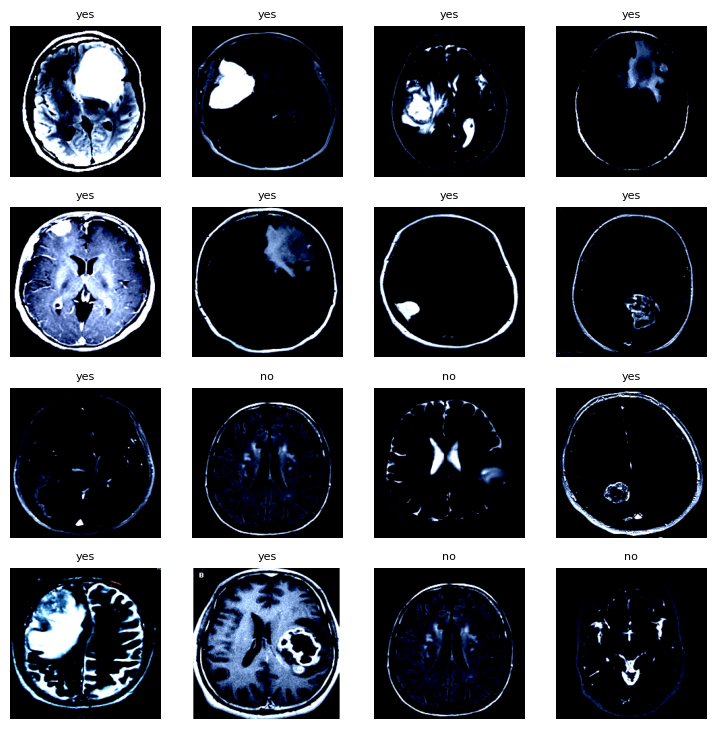

In [7]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
  image, true_label = train_dataset[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")

  plt.title(f"{classes[true_label]}", fontsize=8)
  plt.axis(False)

# Model

In [8]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights)
model.to(device)
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [9]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

C:\Users\Tomek\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

# Freezing

In [10]:
for param in model.encoder.parameters():
  param.requires_grad = False

for param in model.conv_proj.parameters():
  param.requires_grad = False

#summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

# Head Update

In [11]:
model.heads = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(768, 1))

In [12]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

# Loss function and optimizer

In [13]:
loss_fn = nn.BCEWithLogitsLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [14]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [15]:
EPOCHS = 30

program_starts = time.time()
for epoch in tqdm(range(EPOCHS)):
  train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
  test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Training Loss: {train_loss} | Test Loss: {test_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 0.6775662302970886 | Test Loss: 0.5487187504768372 | Test acc: 68.62745098039215%
Epoch: 2 | Training Loss: 0.5535944104194641 | Test Loss: 0.44693833589553833 | Test acc: 90.19607843137256%
Epoch: 3 | Training Loss: 0.4819397032260895 | Test Loss: 0.39531996846199036 | Test acc: 94.11764705882354%
Epoch: 4 | Training Loss: 0.4116933047771454 | Test Loss: 0.34995999932289124 | Test acc: 94.11764705882354%
Epoch: 5 | Training Loss: 0.3639763593673706 | Test Loss: 0.3261971175670624 | Test acc: 94.11764705882354%
Epoch: 6 | Training Loss: 0.3353860378265381 | Test Loss: 0.2946719825267792 | Test acc: 96.07843137254902%
Epoch: 7 | Training Loss: 0.3094327747821808 | Test Loss: 0.27221912145614624 | Test acc: 96.07843137254902%
Epoch: 8 | Training Loss: 0.2962140738964081 | Test Loss: 0.26103925704956055 | Test acc: 96.07843137254902%
Epoch: 9 | Training Loss: 0.27699732780456543 | Test Loss: 0.25516921281814575 | Test acc: 96.07843137254902%
Epoch: 10 | Training 

# Plot

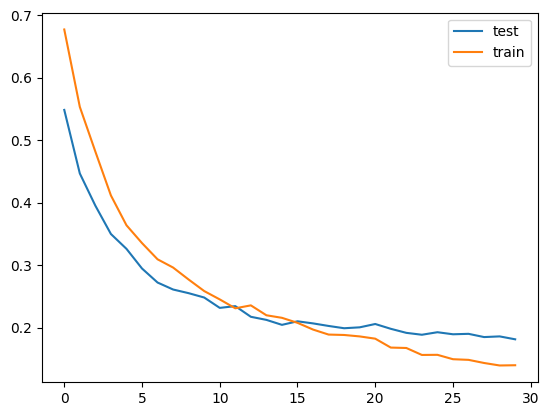

In [16]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

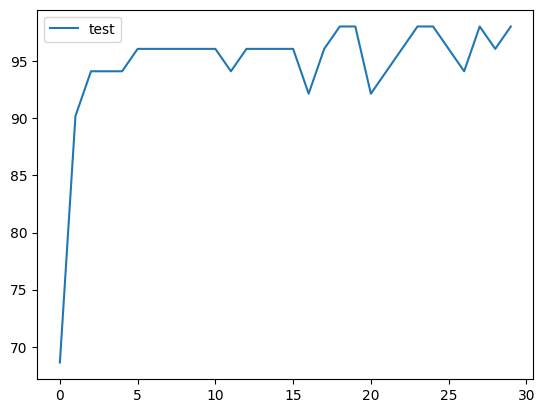

In [17]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

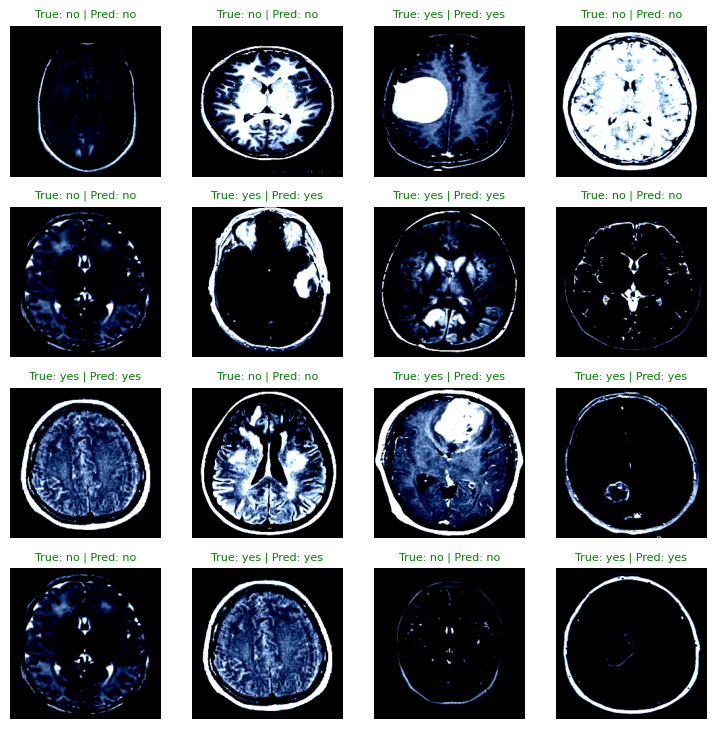

In [18]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
  image, true_label = test_dataset[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

## Confusion matrix

  0%|          | 0/51 [00:00<?, ?it/s]

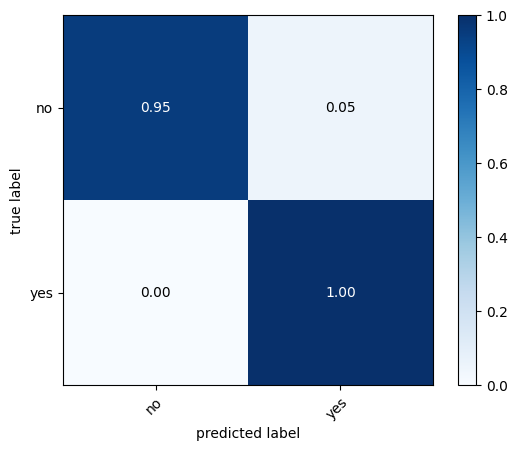

In [19]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

y_preds = []
true_labels = []

for i in tqdm(range(len(test_dataset))):
  image, true_label = test_dataset[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()
  y_preds.append(predicted_label)
  true_labels.append(true_label)

y_preds = torch.tensor(y_preds).squeeze()
true_labels = torch.tensor(true_labels).squeeze()

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
matrix = np.array(confmat(y_preds, true_labels))

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()

In [22]:
print([loss.item() for loss in train_losses])
print([loss.item() for loss in test_losses])
print(test_accuracies)
print([[int(i) for i in row]for row in matrix])

[0.6775662302970886, 0.5535944104194641, 0.4819397032260895, 0.4116933047771454, 0.3639763593673706, 0.3353860378265381, 0.3094327747821808, 0.2962140738964081, 0.27699732780456543, 0.2585606575012207, 0.24518831074237823, 0.23094454407691956, 0.23564641177654266, 0.21978671848773956, 0.2156895250082016, 0.20767240226268768, 0.1968849152326584, 0.18886055052280426, 0.1882137656211853, 0.18590690195560455, 0.18229475617408752, 0.16803334653377533, 0.16737310588359833, 0.15622682869434357, 0.15641702711582184, 0.14938808977603912, 0.1483607292175293, 0.1433507353067398, 0.1393580287694931, 0.13973061740398407]
[0.5487187504768372, 0.44693833589553833, 0.39531996846199036, 0.34995999932289124, 0.3261971175670624, 0.2946719825267792, 0.27221912145614624, 0.26103925704956055, 0.25516921281814575, 0.2482045590877533, 0.2316111922264099, 0.23444479703903198, 0.21734295785427094, 0.2123950570821762, 0.20443876087665558, 0.2101106494665146, 0.20676355063915253, 0.20266294479370117, 0.1990084648